# Qwen3でのphi測定
このノートブックでは、Qwen3モデルのmacOS環境での動作を検証し、シンプルなタスクにおけるPhiの値の挙動を確認します。

## 検証項目
1. 🤖 Qwen3の動作確認（chat_templateの適用なし）
2. 🔄 chat_templateの適用（chat_templateの適用方法を確認。結果がどのようにかわるかを観察）
3. 🧠 Thinking Modeの適用（thinkin modelの有り無しでの違いの確認）



## 🛠 Step 0: モデルの準備

In [2]:
import os

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import time
import numpy as np
from scipy.stats import entropy
from sklearn.feature_selection import mutual_info_regression
# from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


/Users/s20406/script/seminar/alife/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 0: モデルの準備
export_dir = "result"
t0 = time.time()
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"✅ モデル`{model_name}`読み込み完了 in {time.time() - t0:.2f}秒")


✅ モデル`Qwen/Qwen3-0.6B`読み込み完了 in 2.24秒


In [4]:
# Mutual Information Calculation Functions
def calculate_mutual_information_knn(state1, state2, k=3):
    """
    Calculate mutual information between two hidden states using k-NN method.
    This is more appropriate for continuous variables than discretization.
    
    Args:
        state1, state2: torch tensors representing hidden states
        k: number of nearest neighbors for estimation
    
    Returns:
        float: mutual information value
    """
    # Flatten the states to 1D
    flat1 = state1.flatten().detach().cpu().numpy()
    flat2 = state2.flatten().detach().cpu().numpy()
    
    # Ensure same length
    min_len = min(len(flat1), len(flat2))
    flat1 = flat1[:min_len]
    flat2 = flat2[:min_len]
    
    # Use sklearn's mutual_info_regression for continuous variables
    # Reshape for sklearn (samples, features)
    X = flat1.reshape(-1, 1)
    y = flat2
    
    # Calculate mutual information
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)[0]
    
    return mi

def calculate_phi_knn(state1, state2, split_index=1, k=3):
    """
    Calculate phi (integrated information) between two hidden states using k-NN method.
    Phi measures the difference between total mutual information and the sum of 
    mutual information of split fragments.
    
    Args:
        state1, state2: torch tensors representing hidden states
        split_index: integer index to split the states (default 1)
        k: number of nearest neighbors for estimation
    
    Returns:
        float: phi value (total MI - sum of fragment MIs)
    """
    # Calculate total mutual information
    total_mi = calculate_mutual_information_knn(state1, state2, k)
    
    # Flatten the states to 1D
    flat1 = state1.flatten().detach().cpu().numpy()
    flat2 = state2.flatten().detach().cpu().numpy()
    
    # Ensure same length
    min_len = min(len(flat1), len(flat2))
    flat1 = flat1[:min_len]
    flat2 = flat2[:min_len]
    
    # Split the states at split_index
    if split_index >= min_len:
        split_index = min_len // 2  # Use middle if split_index is too large
    
    # Create fragments
    frag1_1 = flat1[:split_index]
    frag1_2 = flat1[split_index:]
    frag2_1 = flat2[:split_index]
    frag2_2 = flat2[split_index:]
    
    # Calculate mutual information for each fragment
    mi_frag1 = 0.0
    mi_frag2 = 0.0
    
    if len(frag1_1) > 0 and len(frag2_1) > 0:
        # Ensure same length for fragment 1
        min_frag1_len = min(len(frag1_1), len(frag2_1))
        if min_frag1_len > 0:
            X_frag1 = frag1_1[:min_frag1_len].reshape(-1, 1)
            y_frag1 = frag2_1[:min_frag1_len]
            mi_frag1 = mutual_info_regression(X_frag1, y_frag1, discrete_features=False, random_state=42)[0]
    
    if len(frag1_2) > 0 and len(frag2_2) > 0:
        # Ensure same length for fragment 2
        min_frag2_len = min(len(frag1_2), len(frag2_2))
        if min_frag2_len > 0:
            X_frag2 = frag1_2[:min_frag2_len].reshape(-1, 1)
            y_frag2 = frag2_2[:min_frag2_len]
            mi_frag2 = mutual_info_regression(X_frag2, y_frag2, discrete_features=False, random_state=42)[0]
    
    # Calculate phi as total MI minus sum of fragment MIs
    phi = total_mi - (mi_frag1 + mi_frag2)
    
    return phi

def calculate_mutual_information_discretized(state1, state2, bins=50):
    """
    Calculate mutual information using discretization (binning) method.
    This is the original method, kept for comparison.
    
    Args:
        state1, state2: torch tensors representing hidden states
        bins: number of bins for discretization
    
    Returns:
        float: mutual information value
    """
    # Flatten the states to 1D
    flat1 = state1.flatten().detach().cpu().numpy()
    flat2 = state2.flatten().detach().cpu().numpy()
    
    # Ensure same length
    min_len = min(len(flat1), len(flat2))
    flat1 = flat1[:min_len]
    flat2 = flat2[:min_len]
    
    # Discretize the continuous values into bins
    hist1, bin_edges1 = np.histogram(flat1, bins=bins)
    hist2, bin_edges2 = np.histogram(flat2, bins=bins)
    
    # Create joint histogram
    joint_hist, _, _ = np.histogram2d(flat1, flat2, bins=bins)
    
    # Normalize to get probabilities
    joint_prob = joint_hist / np.sum(joint_hist)
    prob1 = hist1 / np.sum(hist1)
    prob2 = hist2 / np.sum(hist2)
    
    # Calculate mutual information
    mi = 0.0
    for i in range(bins):
        for j in range(bins):
            if joint_prob[i, j] > 0 and prob1[i] > 0 and prob2[j] > 0:
                mi += joint_prob[i, j] * np.log2(joint_prob[i, j] / (prob1[i] * prob2[j]))
    
    return mi

def compute_mutual_information_matrix(hidden_states_list, method='knn', split_index=1):
    """
    Compute n×n mutual information matrix for n hidden states.
    
    Args:
        hidden_states_list: list of hidden states (tensors)
        method: 'knn' for k-nearest neighbors, 'discretized' for binning, or 'phi' for integrated information
        split_index: integer index to split states for phi calculation (default 1)
    
    Returns:
        numpy array: n×n mutual information matrix
    """
    n = len(hidden_states_list)
    mi_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                # Self-mutual information (entropy)
                flat_state = hidden_states_list[i].flatten().detach().cpu().numpy()
                hist, _ = np.histogram(flat_state, bins=50)
                prob = hist / np.sum(hist)
                prob = prob[prob > 0]  # Remove zero probabilities
                mi_matrix[i, j] = entropy(prob, base=2)
            else:
                if method == 'knn':
                    mi_matrix[i, j] = calculate_mutual_information_knn(
                        hidden_states_list[i], 
                        hidden_states_list[j]
                    )
                elif method == 'phi':
                    mi_matrix[i, j] = calculate_phi_knn(
                        hidden_states_list[i], 
                        hidden_states_list[j],
                        split_index=split_index
                    )
                else:  # discretized
                    mi_matrix[i, j] = calculate_mutual_information_discretized(
                        hidden_states_list[i], 
                        hidden_states_list[j]
                    )
    
    return mi_matrix

def visualize_mi_matrix(mi_matrix, title="Mutual Information Matrix", save_path=None):
    """Visualize the mutual information matrix as a heatmap."""
    plt.figure(figsize=(8, 6))
    im = plt.imshow(mi_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(im, label='Mutual Information')
    plt.title(title)
    plt.xlabel('State Index')
    plt.ylabel('State Index')
    
    # Add text annotations
    for i in range(mi_matrix.shape[0]):
        for j in range(mi_matrix.shape[1]):
            plt.text(j, i, f'{mi_matrix[i, j]:.3f}', 
                    ha='center', va='center', color='white', fontsize=8)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        os.makedirs(export_dir, exist_ok=True)
        plt.savefig(os.path.join(export_dir, save_path), dpi=300, bbox_inches='tight')
        print(f"📊 Figure saved to: {os.path.join(export_dir, save_path)}")
    
    plt.show()

print("✅ Mutual information calculation functions loaded!")
print("📝 Available methods:")
print("   - 'knn': k-Nearest Neighbors method (recommended for continuous variables)")
print("   - 'discretized': Binning method (traditional approach)")
print("   - 'phi': Integrated information (phi) calculation")
print("💡 The 'knn' method is more appropriate for continuous hidden states!")
print("💡 The 'phi' method measures integrated information by comparing total MI with fragment MIs!")


✅ Mutual information calculation functions loaded!
📝 Available methods:
   - 'knn': k-Nearest Neighbors method (recommended for continuous variables)
   - 'discretized': Binning method (traditional approach)
   - 'phi': Integrated information (phi) calculation
💡 The 'knn' method is more appropriate for continuous hidden states!
💡 The 'phi' method measures integrated information by comparing total MI with fragment MIs!


In [5]:
# test_prompt = "Tell me a truth about artificial intelligence."
# test_prompt = "Tell me a lie about artificial intelligence."
truth_prompt = "Tell me a truth about artificial intelligence. Can you explain what it is?"
lie_prompt = "Tell me a lie about artificial intelligence. Can you explain what it is?"


## 🤖 Step 1: Qwen3の動作確認（chat_templateの適用なし）


In [6]:
# Step 1a: Truth prompt analysis
print("🔍 Step 1a: Truth Prompt Analysis")
print("=" * 40)

# encode the truth prompt
inputs = tokenizer.encode(truth_prompt, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=128, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
truth_result = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
truth_hidden_states = outputs.hidden_states  # List of tuples (one per generation step)
print(f"Truth prompt hidden states extracted: {len(truth_hidden_states)} generation steps")
print(f"Each step has {len(truth_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {truth_hidden_states[0][0].shape}")

# print the truth prompt and result
print(f"\n📝 Truth prompt:\n{truth_prompt}")
print("=" * 50)
print(f"📤 Truth result:\n{truth_result[len(truth_prompt):]}")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🔍 Step 1a: Truth Prompt Analysis
Truth prompt hidden states extracted: 128 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 15, 1024])

📝 Truth prompt:
Tell me a truth about artificial intelligence. Can you explain what it is?
📤 Truth result:
 What are the benefits and drawbacks of using AI? What are some examples of AI in everyday life? What are some AI-related jobs? What are some AI-related technologies? What are some AI-related companies? What are some AI-related challenges? What are some AI-related policies? What are some AI-related research areas? What are some AI-related tools? What are some AI-related applications? What are some AI-related trends? What are some AI-related challenges? What are some AI-related technologies? What are some AI-related companies? What are some AI-related challenges? What are some AI-related technologies? What are some AI-related companies? What are


In [7]:
# Step 1b: Lie prompt analysis
print("🔍 Step 1b: Lie Prompt Analysis")
print("=" * 40)

# encode the lie prompt
inputs = tokenizer.encode(lie_prompt, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=128, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
lie_result = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
lie_hidden_states = outputs.hidden_states  # List of tuples (one per generation step)
print(f"Lie prompt hidden states extracted: {len(lie_hidden_states)} generation steps")
print(f"Each step has {len(lie_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {lie_hidden_states[0][0].shape}")

# print the lie prompt and result
print(f"\n📝 Lie prompt:\n{lie_prompt}")
print("=" * 50)
print(f"📤 Lie result:\n{lie_result[len(lie_prompt):]}")


🔍 Step 1b: Lie Prompt Analysis
Lie prompt hidden states extracted: 128 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 15, 1024])

📝 Lie prompt:
Tell me a lie about artificial intelligence. Can you explain what it is?
📤 Lie result:
 What are the benefits and drawbacks of using it? What are the possible future developments? What are the possible risks and challenges? What are the possible solutions? What are the possible consequences? What are the possible ethical issues? What are the possible security concerns? What are the possible environmental concerns? What are the possible social issues? What are the possible economic issues? What are the possible political issues? What are the possible cultural issues? What are the possible technological issues? What are the possible scientific issues? What are the possible philosophical issues? What are the possible ethical issues? What are the possible security concerns? What are the possi

🔍 Mutual Information Analysis - Step 1 Raw Truth vs Lie
📊 Analyzing Truth Prompt (Raw)...
Truth raw MI matrix shape: (128, 128)
📊 Analyzing Lie Prompt (Raw)...
Lie raw MI matrix shape: (128, 128)

🔄 Step 1 Raw Truth vs Lie Comparison:
Truth raw matrix shape: (128, 128)
Lie raw matrix shape: (128, 128)
Using first 128 dimensions for comparison

📈 Step 1 Raw Truth vs Lie Statistics:
Mean MI difference (Lie - Truth): -0.0115
Max MI difference: 1.9398
Min MI difference: -2.3667
Std MI difference: 0.3223
📊 Figure saved to: result/step1_raw_comparison.png


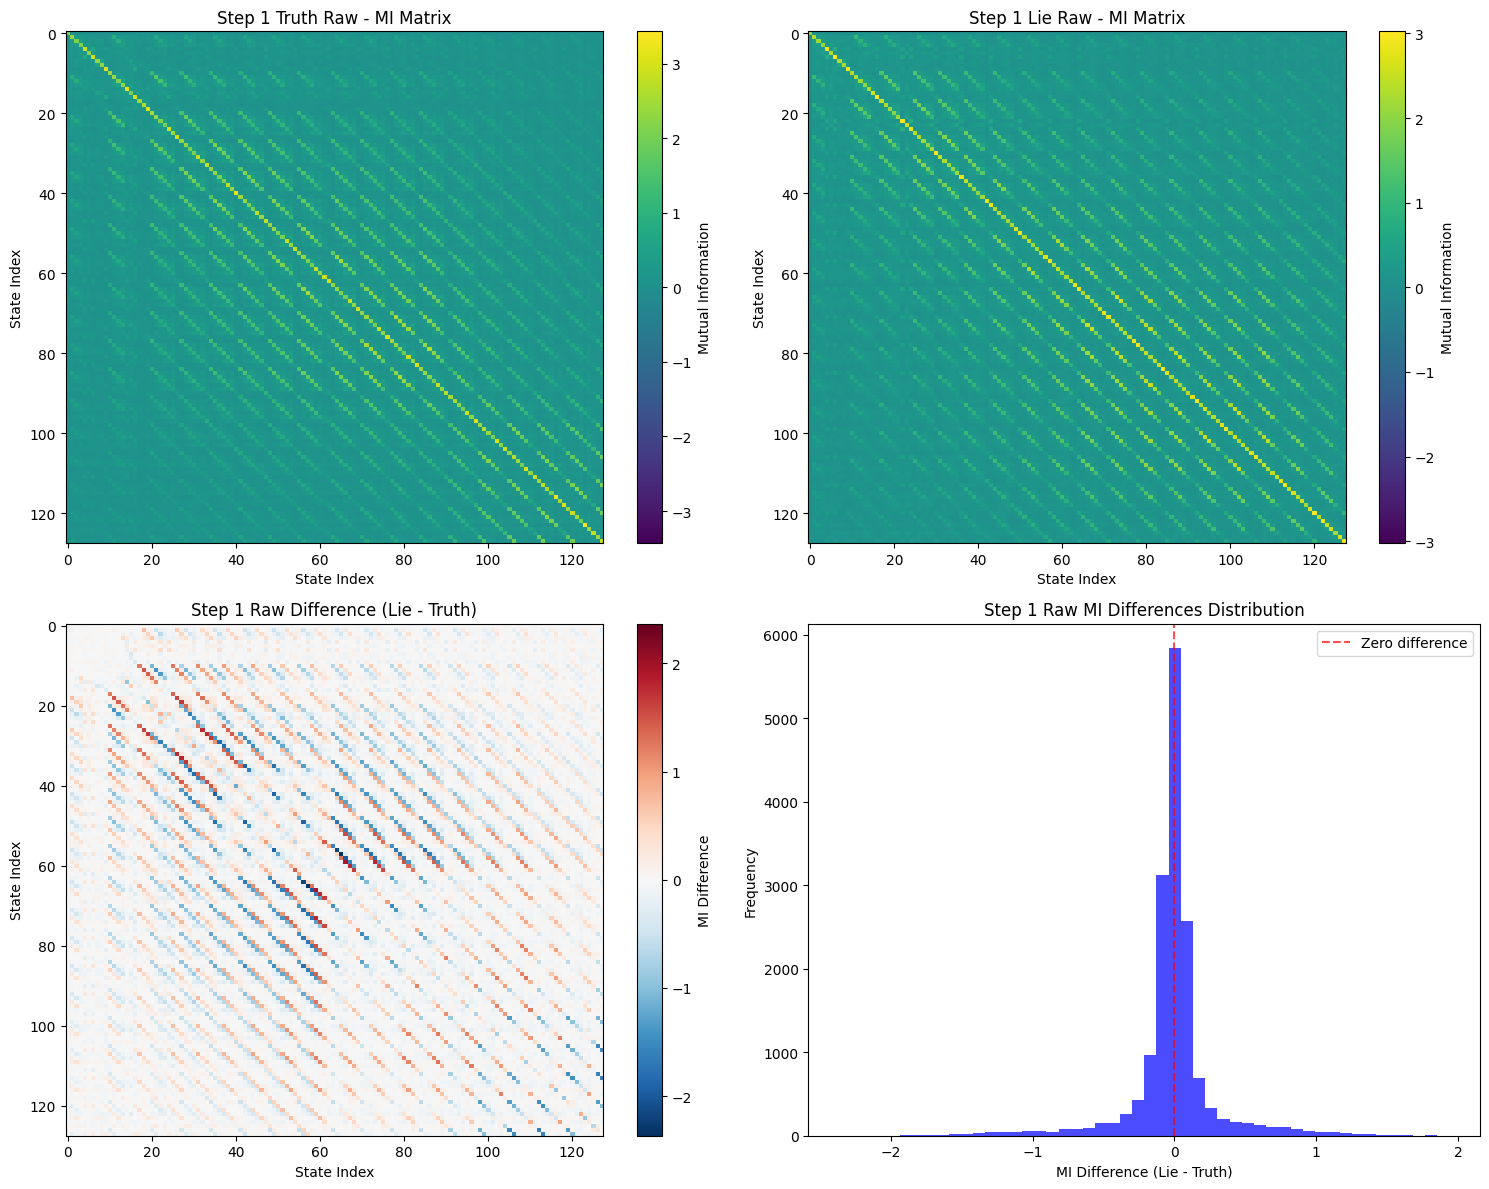

In [9]:
# Mutual Information Analysis for Step 1 (Raw Truth vs Lie)
print("🔍 Mutual Information Analysis - Step 1 Raw Truth vs Lie")
print("=" * 70)

# Analyze truth prompt (raw)
if 'truth_hidden_states' in locals() and len(truth_hidden_states) > 0:
    print("📊 Analyzing Truth Prompt (Raw)...")
    truth_last_layer_states = [step[-1] for step in truth_hidden_states]
    mi_matrix_truth_raw = compute_mutual_information_matrix(truth_last_layer_states, method='knn')
    print(f"Truth raw MI matrix shape: {mi_matrix_truth_raw.shape}")
else:
    print("⚠️ No truth raw hidden states found for Step 1 analysis")

# Analyze lie prompt (raw)
if 'lie_hidden_states' in locals() and len(lie_hidden_states) > 0:
    print("📊 Analyzing Lie Prompt (Raw)...")
    lie_last_layer_states = [step[-1] for step in lie_hidden_states]
    mi_matrix_lie_raw = compute_mutual_information_matrix(lie_last_layer_states, method='knn')
    print(f"Lie raw MI matrix shape: {mi_matrix_lie_raw.shape}")
else:
    print("⚠️ No lie raw hidden states found for Step 1 analysis")

# Compare truth vs lie for Step 1 (raw)
if 'mi_matrix_truth_raw' in locals() and 'mi_matrix_lie_raw' in locals():
    print(f"\n🔄 Step 1 Raw Truth vs Lie Comparison:")
    print(f"Truth raw matrix shape: {mi_matrix_truth_raw.shape}")
    print(f"Lie raw matrix shape: {mi_matrix_lie_raw.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(mi_matrix_truth_raw.shape[0], mi_matrix_lie_raw.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_raw_truncated = mi_matrix_truth_raw[:min_size, :min_size]
    lie_raw_truncated = mi_matrix_lie_raw[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_raw = lie_raw_truncated - truth_raw_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 1 Raw Truth vs Lie Statistics:")
    print(f"Mean MI difference (Lie - Truth): {np.mean(diff_matrix_raw):.4f}")
    print(f"Max MI difference: {np.max(diff_matrix_raw):.4f}")
    print(f"Min MI difference: {np.min(diff_matrix_raw):.4f}")
    print(f"Std MI difference: {np.std(diff_matrix_raw):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth raw matrix - centered at 0
    vmax_mi = max(np.abs(truth_raw_truncated.min()), np.abs(truth_raw_truncated.max()))
    im1 = axes[0, 0].imshow(truth_raw_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 0].set_title('Step 1 Truth Raw - MI Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Mutual Information')
    
    # Lie raw matrix - centered at 0
    vmax_mi = max(np.abs(lie_raw_truncated.min()), np.abs(lie_raw_truncated.max()))
    im2 = axes[0, 1].imshow(lie_raw_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 1].set_title('Step 1 Lie Raw - MI Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Mutual Information')
    
    # Difference matrix - white at 0
    vmax_diff = max(np.abs(diff_matrix_raw.min()), np.abs(diff_matrix_raw.max()))
    im3 = axes[1, 0].imshow(diff_matrix_raw, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    axes[1, 0].set_title('Step 1 Raw Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='MI Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_raw.flatten(), bins=50, alpha=0.7, color='blue')
    axes[1, 1].set_title('Step 1 Raw MI Differences Distribution')
    axes[1, 1].set_xlabel('MI Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step1_raw_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step1_raw_comparison.png')}")
    
    plt.show()
    
    # Save for later comparison
    step1_truth_raw_mi_matrix = mi_matrix_truth_raw.copy()
    step1_lie_raw_mi_matrix = mi_matrix_lie_raw.copy()
    
else:
    print("⚠️ Need both truth and lie raw MI matrices for Step 1 comparison")


🔍 Phi Analysis - Step 1 Raw Truth vs Lie
📊 Analyzing Truth Prompt (Raw) with Phi...
Truth raw Phi matrix shape: (128, 128)
📊 Analyzing Lie Prompt (Raw) with Phi...
Lie raw Phi matrix shape: (128, 128)

🔄 Step 1 Raw Truth vs Lie Phi Comparison:
Truth raw phi matrix shape: (128, 128)
Lie raw phi matrix shape: (128, 128)
Using first 128 dimensions for comparison

📈 Step 1 Raw Truth vs Lie Phi Statistics:
Mean Phi difference (Lie - Truth): 0.0092
Max Phi difference: 2.2220
Min Phi difference: -1.9072
Std Phi difference: 0.3206
📊 Figure saved to: result/step1_raw_phi_comparison.png


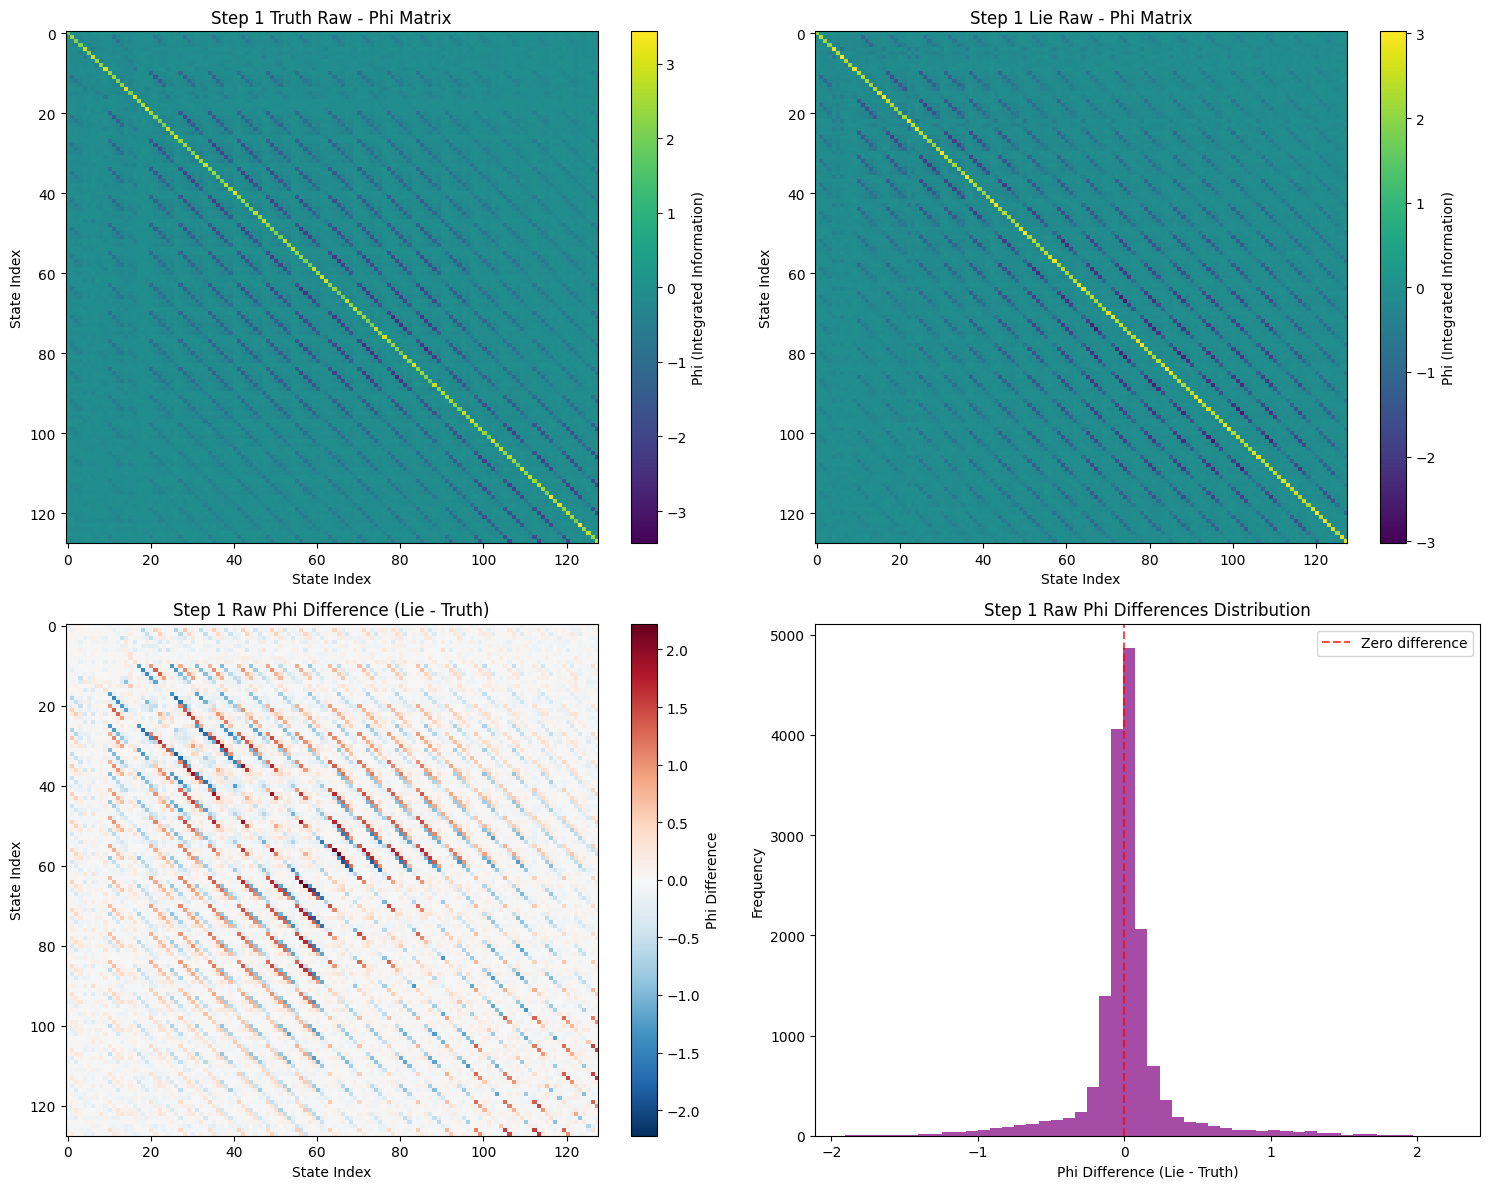


💡 Step 1 Raw Phi Analysis Insights:
   - Phi measures integrated information (total MI - sum of fragment MIs)
   - Positive differences indicate higher integrated information in lie responses
   - Negative differences indicate higher integrated information in truth responses
   - Phi values close to zero suggest fragmented information processing


In [10]:
# Phi Analysis for Step 1 (Raw Truth vs Lie)
print("🔍 Phi Analysis - Step 1 Raw Truth vs Lie")
print("=" * 70)

# Analyze truth prompt (raw) with phi
if 'truth_hidden_states' in locals() and len(truth_hidden_states) > 0:
    print("📊 Analyzing Truth Prompt (Raw) with Phi...")
    truth_last_layer_states = [step[-1] for step in truth_hidden_states]
    phi_matrix_truth_raw = compute_mutual_information_matrix(truth_last_layer_states, method='phi', split_index=torch.numel(truth_last_layer_states[0])//2)
    print(f"Truth raw Phi matrix shape: {phi_matrix_truth_raw.shape}")
else:
    print("⚠️ No truth raw hidden states found for Step 1 phi analysis")

# Analyze lie prompt (raw) with phi
if 'lie_hidden_states' in locals() and len(lie_hidden_states) > 0:
    print("📊 Analyzing Lie Prompt (Raw) with Phi...")
    lie_last_layer_states = [step[-1] for step in lie_hidden_states]
    phi_matrix_lie_raw = compute_mutual_information_matrix(lie_last_layer_states, method='phi', split_index=torch.numel(lie_last_layer_states[0])//2)
    print(f"Lie raw Phi matrix shape: {phi_matrix_lie_raw.shape}")
else:
    print("⚠️ No lie raw hidden states found for Step 1 phi analysis")

# Compare truth vs lie for Step 1 (raw) with phi
if 'phi_matrix_truth_raw' in locals() and 'phi_matrix_lie_raw' in locals():
    print(f"\n🔄 Step 1 Raw Truth vs Lie Phi Comparison:")
    print(f"Truth raw phi matrix shape: {phi_matrix_truth_raw.shape}")
    print(f"Lie raw phi matrix shape: {phi_matrix_lie_raw.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(phi_matrix_truth_raw.shape[0], phi_matrix_lie_raw.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_raw_phi_truncated = phi_matrix_truth_raw[:min_size, :min_size]
    lie_raw_phi_truncated = phi_matrix_lie_raw[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_raw_phi = lie_raw_phi_truncated - truth_raw_phi_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 1 Raw Truth vs Lie Phi Statistics:")
    print(f"Mean Phi difference (Lie - Truth): {np.mean(diff_matrix_raw_phi):.4f}")
    print(f"Max Phi difference: {np.max(diff_matrix_raw_phi):.4f}")
    print(f"Min Phi difference: {np.min(diff_matrix_raw_phi):.4f}")
    print(f"Std Phi difference: {np.std(diff_matrix_raw_phi):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth raw phi matrix - centered at 0
    vmax_phi = max(np.abs(truth_raw_phi_truncated.min()), np.abs(truth_raw_phi_truncated.max()))
    im1 = axes[0, 0].imshow(truth_raw_phi_truncated, cmap='viridis', aspect='auto', vmin=-vmax_phi, vmax=vmax_phi)
    axes[0, 0].set_title('Step 1 Truth Raw - Phi Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Phi (Integrated Information)')
    
    # Lie raw phi matrix - centered at 0
    vmax_phi = max(np.abs(lie_raw_phi_truncated.min()), np.abs(lie_raw_phi_truncated.max()))
    im2 = axes[0, 1].imshow(lie_raw_phi_truncated, cmap='viridis', aspect='auto', vmin=-vmax_phi, vmax=vmax_phi)
    axes[0, 1].set_title('Step 1 Lie Raw - Phi Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Phi (Integrated Information)')
    
    # Difference matrix - white at 0
    vmax_diff_phi = max(np.abs(diff_matrix_raw_phi.min()), np.abs(diff_matrix_raw_phi.max()))
    im3 = axes[1, 0].imshow(diff_matrix_raw_phi, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff_phi, vmax=vmax_diff_phi)
    axes[1, 0].set_title('Step 1 Raw Phi Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='Phi Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_raw_phi.flatten(), bins=50, alpha=0.7, color='purple')
    axes[1, 1].set_title('Step 1 Raw Phi Differences Distribution')
    axes[1, 1].set_xlabel('Phi Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step1_raw_phi_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step1_raw_phi_comparison.png')}")
    
    plt.show()
    
    # Save for later comparison
    step1_truth_raw_phi_matrix = phi_matrix_truth_raw.copy()
    step1_lie_raw_phi_matrix = phi_matrix_lie_raw.copy()
    
    print(f"\n💡 Step 1 Raw Phi Analysis Insights:")
    print(f"   - Phi measures integrated information (total MI - sum of fragment MIs)")
    print(f"   - Positive differences indicate higher integrated information in lie responses")
    print(f"   - Negative differences indicate higher integrated information in truth responses")
    print(f"   - Phi values close to zero suggest fragmented information processing")
    
else:
    print("⚠️ Need both truth and lie raw Phi matrices for Step 1 comparison")


## 🔄 Step 2: chat_templateの適用


In [11]:
# Step 2a: Truth prompt with chat_template（enable_thinking=False）
print("🔍 Step 2a: Truth Prompt with Chat Template")
print("=" * 50)

messages = [{"role": "user", "content": truth_prompt}]
chat_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,  # 生成プロンプトを追加
    enable_thinking=False        # Thinking Modeを無効化
)

# encode the chat prompt
inputs = tokenizer.encode(chat_prompt, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=128, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
truth_chat_result = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
truth_chat_hidden_states = outputs.hidden_states
print(f"Truth chat template hidden states extracted: {len(truth_chat_hidden_states)} generation steps")
print(f"Each step has {len(truth_chat_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {truth_chat_hidden_states[0][0].shape}")

# print the chat prompt and result
print(f"📝 Truth chat prompt:\n{chat_prompt}")
print("=" * 50)
print(f"📤 Truth chat result:\n{truth_chat_result[len(chat_prompt):]}")


🔍 Step 2a: Truth Prompt with Chat Template
Truth chat template hidden states extracted: 128 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 27, 1024])
📝 Truth chat prompt:
<|im_start|>user
Tell me a truth about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant
<think>

</think>


📤 Truth chat result:
Artificial Intelligence (AI) refers to the simulation of human intelligence tasks that are carried out by machines. These tasks include learning, reasoning, problem-solving, perception, and decision-making. AI systems can be used to automate tasks, improve decision-making, and assist in various fields such as healthcare, finance, and education.

AI systems can be implemented in different ways, including machine learning, natural language processing, computer vision, and robotics. AI is a rapidly growing field with many applications and potential benefits. However, it also raises important ethical and

In [12]:
# Step 2b: Lie prompt with chat_template（enable_thinking=False）
print("🔍 Step 2b: Lie Prompt with Chat Template")
print("=" * 50)

messages = [{"role": "user", "content": lie_prompt}]
chat_prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,  # 生成プロンプトを追加
    enable_thinking=False        # Thinking Modeを無効化
)

# encode the chat prompt
inputs = tokenizer.encode(chat_prompt, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=128, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
lie_chat_result = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
lie_chat_hidden_states = outputs.hidden_states
print(f"Lie chat template hidden states extracted: {len(lie_chat_hidden_states)} generation steps")
print(f"Each step has {len(lie_chat_hidden_states[0])} layers")
print(f"Hidden state shape for first step, first layer: {lie_chat_hidden_states[0][0].shape}")

# print the chat prompt and result
print(f"📝 Lie chat prompt:\n{chat_prompt}")
print("=" * 50)
print(f"📤 Lie chat result:\n{lie_chat_result[len(chat_prompt):]}")


🔍 Step 2b: Lie Prompt with Chat Template
Lie chat template hidden states extracted: 104 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 27, 1024])
📝 Lie chat prompt:
<|im_start|>user
Tell me a lie about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant
<think>

</think>


📤 Lie chat result:
Sure! Here's a lie I can tell you:

**"Artificial Intelligence (AI) is a technology that can make things easier for humans, but it's not a real thing. It's just a concept, not a real machine."**

But I want to clarify: **AI is a real technology**. It refers to machines that can perform tasks that typically require human intelligence, like learning, problem-solving, and decision-making. It's a subset of computer science and has many applications in various fields.<|im_end|>


🔍 Mutual Information Analysis - Step 2 Chat Template Truth vs Lie
📊 Analyzing Truth Prompt with Chat Template...
Truth chat MI matrix shape: (128, 128)
📊 Analyzing Lie Prompt with Chat Template...
Lie chat MI matrix shape: (104, 104)

🔄 Step 2 Chat Template Truth vs Lie Comparison:
Truth chat matrix shape: (128, 128)
Lie chat matrix shape: (104, 104)
Using first 104 dimensions for comparison

📈 Step 2 Chat Template Truth vs Lie Statistics:
Mean MI difference (Lie - Truth): 0.0041
Max MI difference: 1.2478
Min MI difference: -1.6011
Std MI difference: 0.1190
📊 Figure saved to: result/step2_chat_template_comparison_v2.png


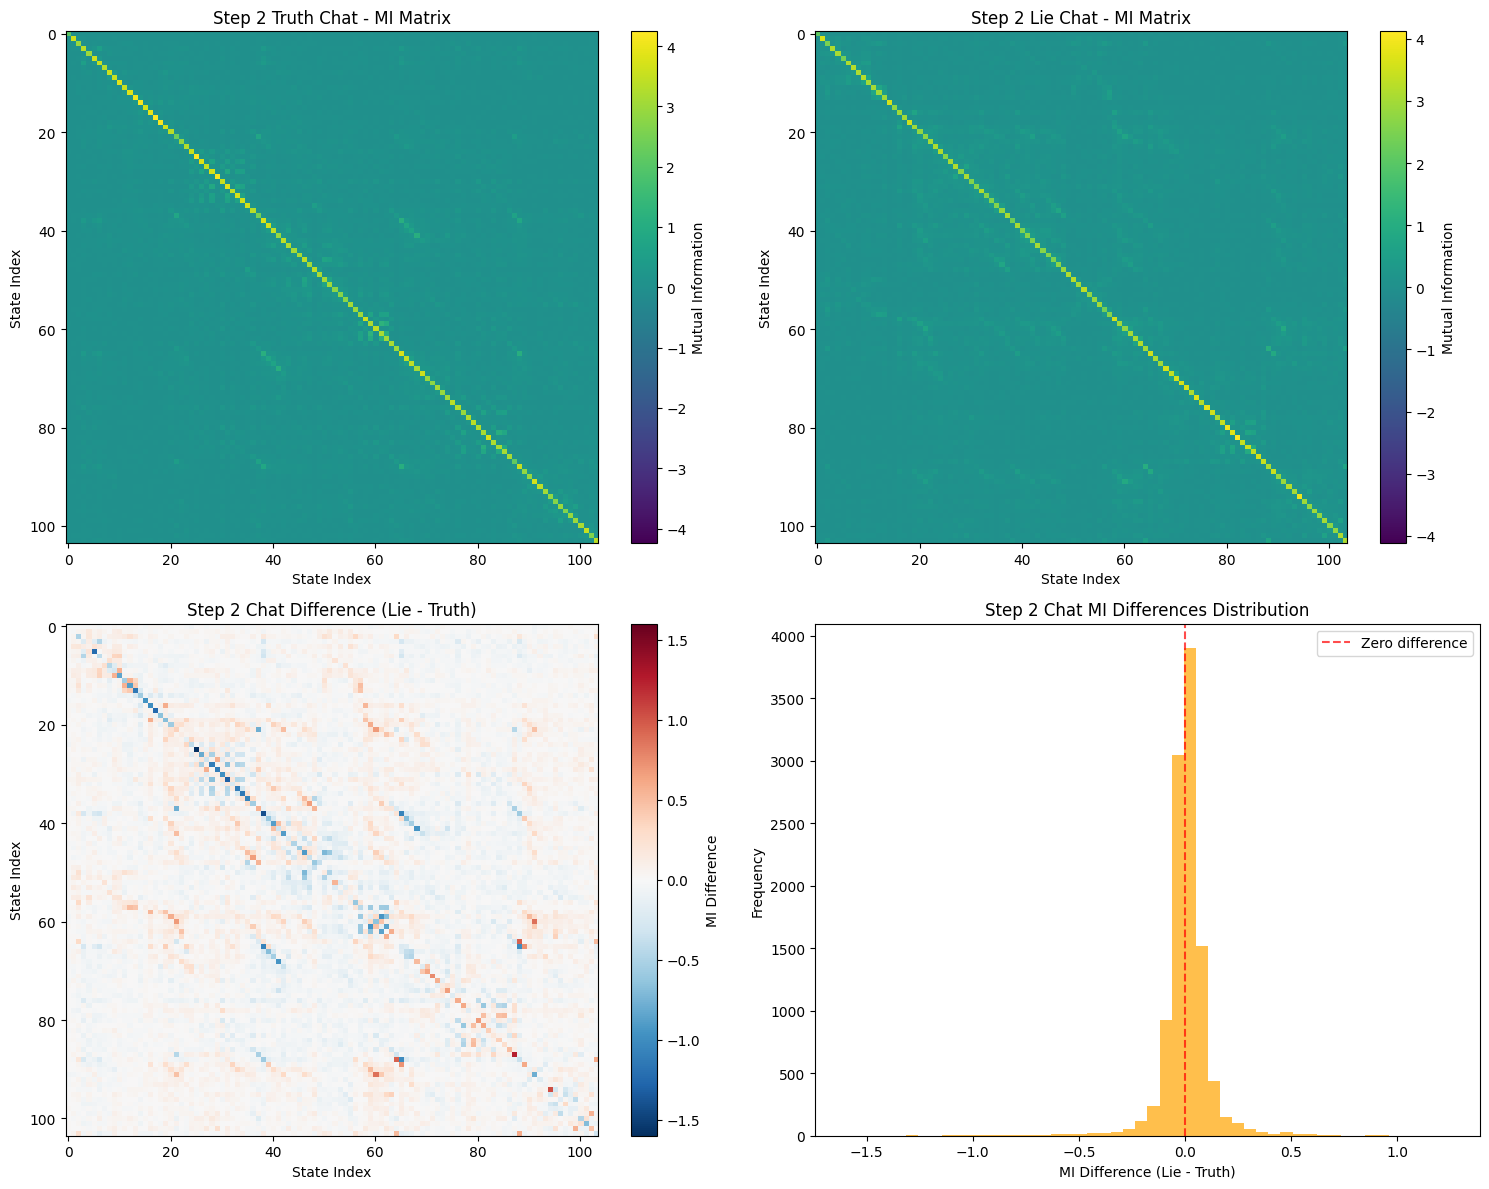

In [13]:
# Mutual Information Analysis for Step 2 (Chat Template Truth vs Lie)
print("🔍 Mutual Information Analysis - Step 2 Chat Template Truth vs Lie")
print("=" * 70)

# Analyze truth prompt with chat template
if 'truth_chat_hidden_states' in locals() and len(truth_chat_hidden_states) > 0:
    print("📊 Analyzing Truth Prompt with Chat Template...")
    truth_chat_last_layer_states = [step[-1] for step in truth_chat_hidden_states]
    mi_matrix_truth_chat = compute_mutual_information_matrix(truth_chat_last_layer_states, method='knn')
    print(f"Truth chat MI matrix shape: {mi_matrix_truth_chat.shape}")
else:
    print("⚠️ No truth chat hidden states found for Step 2 analysis")

# Analyze lie prompt with chat template
if 'lie_chat_hidden_states' in locals() and len(lie_chat_hidden_states) > 0:
    print("📊 Analyzing Lie Prompt with Chat Template...")
    lie_chat_last_layer_states = [step[-1] for step in lie_chat_hidden_states]
    mi_matrix_lie_chat = compute_mutual_information_matrix(lie_chat_last_layer_states, method='knn')
    print(f"Lie chat MI matrix shape: {mi_matrix_lie_chat.shape}")
else:
    print("⚠️ No lie chat hidden states found for Step 2 analysis")

# Compare truth vs lie for Step 2 (chat template)
if 'mi_matrix_truth_chat' in locals() and 'mi_matrix_lie_chat' in locals():
    print(f"\n🔄 Step 2 Chat Template Truth vs Lie Comparison:")
    print(f"Truth chat matrix shape: {mi_matrix_truth_chat.shape}")
    print(f"Lie chat matrix shape: {mi_matrix_lie_chat.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(mi_matrix_truth_chat.shape[0], mi_matrix_lie_chat.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_chat_truncated = mi_matrix_truth_chat[:min_size, :min_size]
    lie_chat_truncated = mi_matrix_lie_chat[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_chat = lie_chat_truncated - truth_chat_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 2 Chat Template Truth vs Lie Statistics:")
    print(f"Mean MI difference (Lie - Truth): {np.mean(diff_matrix_chat):.4f}")
    print(f"Max MI difference: {np.max(diff_matrix_chat):.4f}")
    print(f"Min MI difference: {np.min(diff_matrix_chat):.4f}")
    print(f"Std MI difference: {np.std(diff_matrix_chat):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth chat matrix - centered at 0
    vmax_mi = max(np.abs(truth_chat_truncated.min()), np.abs(truth_chat_truncated.max()))
    im1 = axes[0, 0].imshow(truth_chat_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 0].set_title('Step 2 Truth Chat - MI Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Mutual Information')
    
    # Lie chat matrix - centered at 0
    vmax_mi = max(np.abs(lie_chat_truncated.min()), np.abs(lie_chat_truncated.max()))
    im2 = axes[0, 1].imshow(lie_chat_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 1].set_title('Step 2 Lie Chat - MI Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Mutual Information')
    
    # Difference matrix - white at 0
    vmax_diff = max(np.abs(diff_matrix_chat.min()), np.abs(diff_matrix_chat.max()))
    im3 = axes[1, 0].imshow(diff_matrix_chat, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    axes[1, 0].set_title('Step 2 Chat Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='MI Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_chat.flatten(), bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_title('Step 2 Chat MI Differences Distribution')
    axes[1, 1].set_xlabel('MI Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step2_chat_template_comparison_v2.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step2_chat_template_comparison_v2.png')}")
    
    plt.show()
    
    # Save for later comparison
    step2_truth_chat_mi_matrix = mi_matrix_truth_chat.copy()
    step2_lie_chat_mi_matrix = mi_matrix_lie_chat.copy()
    
else:
    print("⚠️ Need both truth and lie chat MI matrices for Step 2 comparison")


🔍 Phi Analysis - Step 2 Chat Template Truth vs Lie
📊 Analyzing Truth Prompt with Chat Template using Phi...
Truth chat Phi matrix shape: (128, 128)
📊 Analyzing Lie Prompt with Chat Template using Phi...
Lie chat Phi matrix shape: (104, 104)

🔄 Step 2 Chat Template Truth vs Lie Phi Comparison:
Truth chat phi matrix shape: (128, 128)
Lie chat phi matrix shape: (104, 104)
Using first 104 dimensions for comparison

📈 Step 2 Chat Template Truth vs Lie Phi Statistics:
Mean Phi difference (Lie - Truth): -0.0064
Max Phi difference: 1.2478
Min Phi difference: -1.6011
Std Phi difference: 0.1197
📊 Figure saved to: result/step2_chat_phi_comparison.png


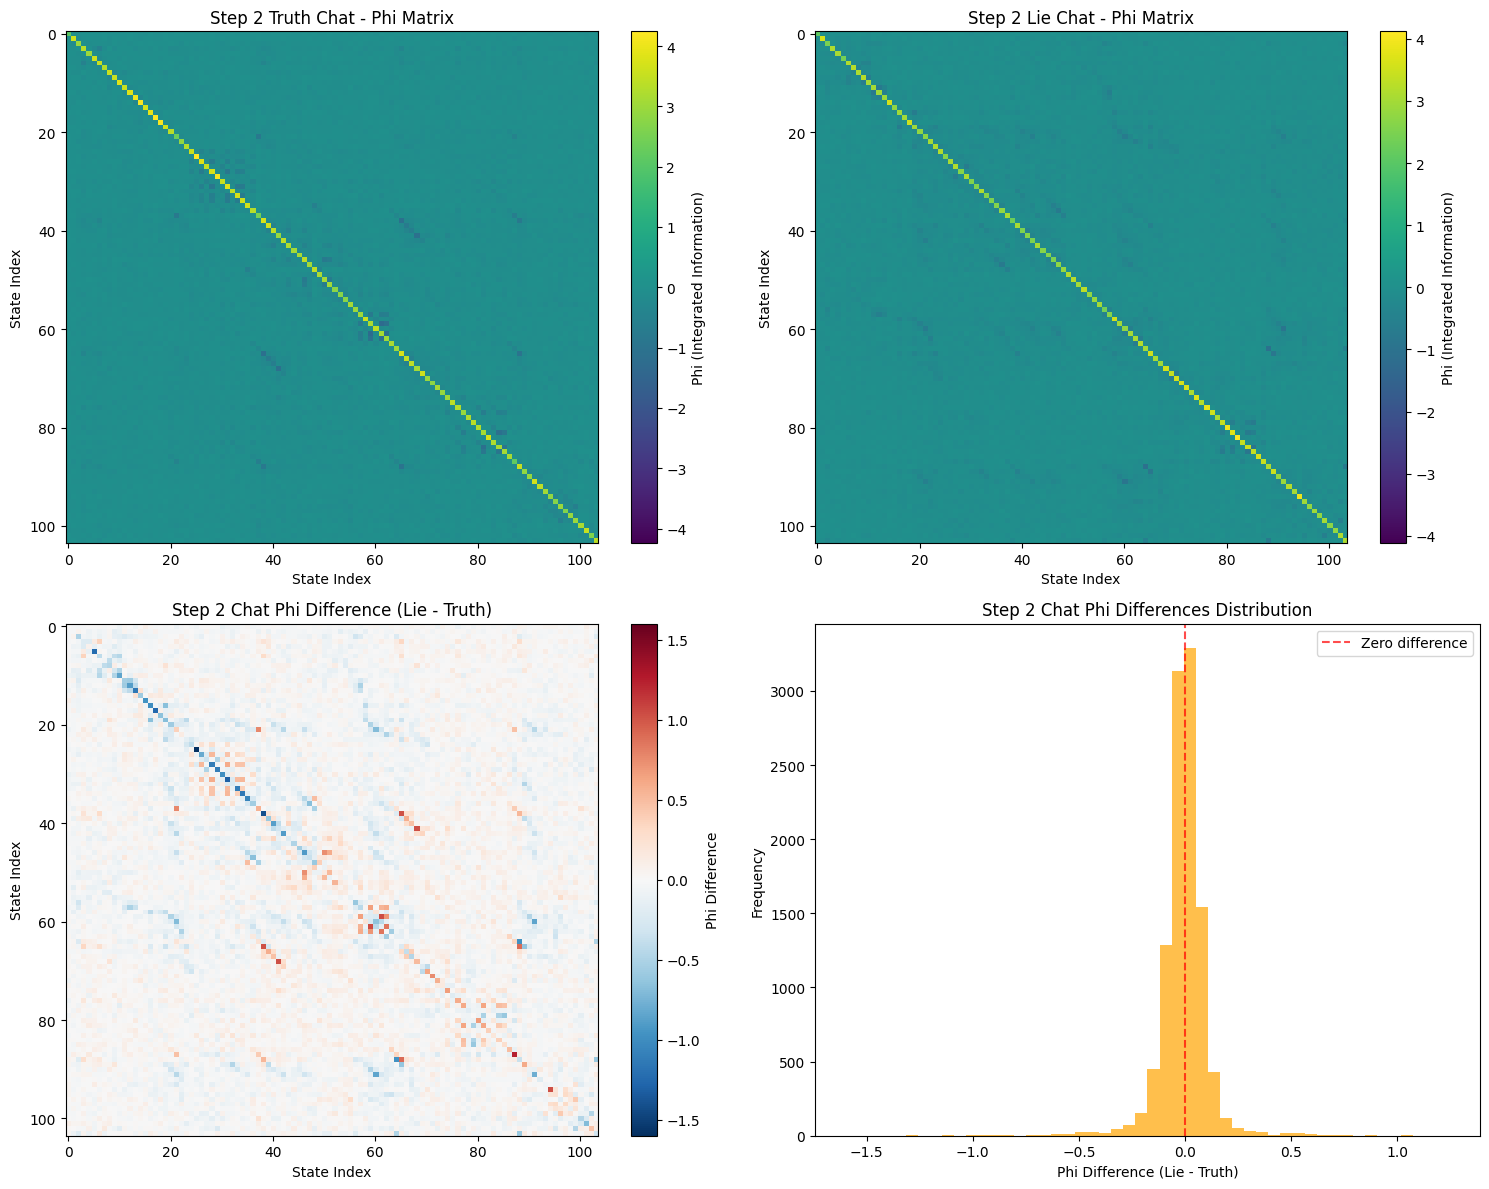


💡 Step 2 Chat Template Phi Analysis Insights:
   - Chat template affects integrated information processing
   - Positive differences indicate higher integrated information in lie responses
   - Negative differences indicate higher integrated information in truth responses
   - Compare with raw results to see template effects on phi


In [15]:
# Phi Analysis for Step 2 (Chat Template Truth vs Lie)
print("🔍 Phi Analysis - Step 2 Chat Template Truth vs Lie")
print("=" * 70)

# Analyze truth prompt with chat template using phi
if 'truth_chat_hidden_states' in locals() and len(truth_chat_hidden_states) > 0:
    print("📊 Analyzing Truth Prompt with Chat Template using Phi...")
    truth_chat_last_layer_states = [step[-1] for step in truth_chat_hidden_states]
    phi_matrix_truth_chat = compute_mutual_information_matrix(truth_chat_last_layer_states, method='phi', split_index=torch.numel(truth_chat_last_layer_states[0])//2)
    print(f"Truth chat Phi matrix shape: {phi_matrix_truth_chat.shape}")
else:
    print("⚠️ No truth chat hidden states found for Step 2 phi analysis")

# Analyze lie prompt with chat template using phi
if 'lie_chat_hidden_states' in locals() and len(lie_chat_hidden_states) > 0:
    print("📊 Analyzing Lie Prompt with Chat Template using Phi...")
    lie_chat_last_layer_states = [step[-1] for step in lie_chat_hidden_states]
    phi_matrix_lie_chat = compute_mutual_information_matrix(lie_chat_last_layer_states, method='phi', split_index=torch.numel(lie_chat_last_layer_states[0])//2)
    print(f"Lie chat Phi matrix shape: {phi_matrix_lie_chat.shape}")
else:
    print("⚠️ No lie chat hidden states found for Step 2 phi analysis")

# Compare truth vs lie for Step 2 (chat template) with phi
if 'phi_matrix_truth_chat' in locals() and 'phi_matrix_lie_chat' in locals():
    print(f"\n🔄 Step 2 Chat Template Truth vs Lie Phi Comparison:")
    print(f"Truth chat phi matrix shape: {phi_matrix_truth_chat.shape}")
    print(f"Lie chat phi matrix shape: {phi_matrix_lie_chat.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(phi_matrix_truth_chat.shape[0], phi_matrix_lie_chat.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_chat_phi_truncated = phi_matrix_truth_chat[:min_size, :min_size]
    lie_chat_phi_truncated = phi_matrix_lie_chat[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_chat_phi = lie_chat_phi_truncated - truth_chat_phi_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 2 Chat Template Truth vs Lie Phi Statistics:")
    print(f"Mean Phi difference (Lie - Truth): {np.mean(diff_matrix_chat_phi):.4f}")
    print(f"Max Phi difference: {np.max(diff_matrix_chat_phi):.4f}")
    print(f"Min Phi difference: {np.min(diff_matrix_chat_phi):.4f}")
    print(f"Std Phi difference: {np.std(diff_matrix_chat_phi):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth chat phi matrix - centered at 0
    vmax_phi = max(np.abs(truth_chat_phi_truncated.min()), np.abs(truth_chat_phi_truncated.max()))
    im1 = axes[0, 0].imshow(truth_chat_phi_truncated, cmap='viridis', aspect='auto', vmin=-vmax_phi, vmax=vmax_phi)
    axes[0, 0].set_title('Step 2 Truth Chat - Phi Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Phi (Integrated Information)')
    
    # Lie chat phi matrix - centered at 0
    vmax_phi = max(np.abs(lie_chat_phi_truncated.min()), np.abs(lie_chat_phi_truncated.max()))
    im2 = axes[0, 1].imshow(lie_chat_phi_truncated, cmap='viridis', aspect='auto', vmin=-vmax_phi, vmax=vmax_phi)
    axes[0, 1].set_title('Step 2 Lie Chat - Phi Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Phi (Integrated Information)')
    
    # Difference matrix - white at 0
    vmax_diff_phi = max(np.abs(diff_matrix_chat_phi.min()), np.abs(diff_matrix_chat_phi.max()))
    im3 = axes[1, 0].imshow(diff_matrix_chat_phi, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff_phi, vmax=vmax_diff_phi)
    axes[1, 0].set_title('Step 2 Chat Phi Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='Phi Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_chat_phi.flatten(), bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_title('Step 2 Chat Phi Differences Distribution')
    axes[1, 1].set_xlabel('Phi Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step2_chat_phi_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step2_chat_phi_comparison.png')}")
    
    plt.show()
    
    # Save for later comparison
    step2_truth_chat_phi_matrix = phi_matrix_truth_chat.copy()
    step2_lie_chat_phi_matrix = phi_matrix_lie_chat.copy()
    
    print(f"\n💡 Step 2 Chat Template Phi Analysis Insights:")
    print(f"   - Chat template affects integrated information processing")
    print(f"   - Positive differences indicate higher integrated information in lie responses")
    print(f"   - Negative differences indicate higher integrated information in truth responses")
    print(f"   - Compare with raw results to see template effects on phi")
    
else:
    print("⚠️ Need both truth and lie chat Phi matrices for Step 2 comparison")


## 🧠 Step 3. Thinking Modeの適用
Thinking Modeを有効にして、思考過程を含めた応答を生成

上記の設定（max_new_tokens=32）だと、おそらくthinking部分が途中で切れてしてしまうので、max_new_tokensを増やして再実行します。

In [16]:
# Step 3a: Truth prompt with thinking mode（enable_thinking=True）
print("🔍 Step 3a: Truth Prompt with Thinking Mode")
print("=" * 50)

# max_new_tokens = 512  # Increased for thinking mode
max_new_tokens = 1024  # Increased for thinking mode

# Chat template適用時に、thinking modeを有効にする
thinking_prompt_truth = tokenizer.apply_chat_template(
    [{"role": "user", "content": truth_prompt}], 
    tokenize=False, 
    add_generation_prompt=True, 
    enable_thinking=True
)

# encode the thinking prompt
inputs = tokenizer.encode(thinking_prompt_truth, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=max_new_tokens, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
thinking_result_truth = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
thinking_hidden_states_truth = outputs.hidden_states
print(f"Truth thinking mode hidden states extracted: {len(thinking_hidden_states_truth)} generation steps")
print(f"Each step has {len(thinking_hidden_states_truth[0])} layers")
print(f"Hidden state shape for first step, first layer: {thinking_hidden_states_truth[0][0].shape}")

# print the thinking prompt and result
print(f"📝 Truth thinking prompt:\n{thinking_prompt_truth}")
print("=" * 50)
print(f"📤 Truth thinking result:\n{thinking_result_truth[len(thinking_prompt_truth):]}")

# Extract thinking and response parts
import re
match = re.search(r'<think>(.*?)</think>(.*)', thinking_result_truth, flags=re.DOTALL)

if match:
    print(f"\n🧠 Truth Thinking:\n{match.group(1).strip()}\n")
    print(f"💬 Truth Response:\n{match.group(2).strip()}")
elif '<think>' in thinking_result_truth:
    think_start = thinking_result_truth.find('<think>') + 7
    thinking_part = thinking_result_truth[think_start:]
    print(f"\n🧠 Truth Thinking (incomplete):\n{thinking_part.strip()}")
    print("⚠️ Thinking generation was truncated")
else:
    print("⚠️ No thinking format detected in truth response")


🔍 Step 3a: Truth Prompt with Thinking Mode
Truth thinking mode hidden states extracted: 427 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 23, 1024])
📝 Truth thinking prompt:
<|im_start|>user
Tell me a truth about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant

📤 Truth thinking result:
<think>
Okay, the user is asking for a truth about artificial intelligence and an explanation. Let me start by recalling what I know. AI is a broad field, so I need to make sure I explain it clearly.

First, I should define AI. It's a branch of computer science that involves machines performing tasks that typically require human intelligence. But I need to mention that it's not just about machines doing tasks, but also about learning and adapting.

Wait, the user might be looking for a concise answer. I should avoid jargon and keep it simple. Maybe start with the definition, then explain the key components like

In [17]:
# Step 3b: Lie prompt with thinking mode（enable_thinking=True）
print("🔍 Step 3b: Lie Prompt with Thinking Mode")
print("=" * 50)

# Chat template適用時に、thinking modeを有効にする
thinking_prompt_lie = tokenizer.apply_chat_template(
    [{"role": "user", "content": lie_prompt}], 
    tokenize=False, 
    add_generation_prompt=True, 
    enable_thinking=True
)

# encode the thinking prompt
inputs = tokenizer.encode(thinking_prompt_lie, return_tensors="pt")

# generate the output with hidden states extraction
with torch.no_grad():
    outputs = model.generate(
        inputs, 
        max_new_tokens=max_new_tokens, 
        do_sample=False,
        output_hidden_states=True,
        return_dict_in_generate=True
    )

# decode the output
thinking_result_lie = tokenizer.decode(outputs.sequences[0], skip_special_tokens=False)

# extract hidden states
thinking_hidden_states_lie = outputs.hidden_states
print(f"Lie thinking mode hidden states extracted: {len(thinking_hidden_states_lie)} generation steps")
print(f"Each step has {len(thinking_hidden_states_lie[0])} layers")
print(f"Hidden state shape for first step, first layer: {thinking_hidden_states_lie[0][0].shape}")

# print the thinking prompt and result
print(f"📝 Lie thinking prompt:\n{thinking_prompt_lie}")
print("=" * 50)
print(f"📤 Lie thinking result:\n{thinking_result_lie[len(thinking_prompt_lie):]}")

# Extract thinking and response parts
match = re.search(r'<think>(.*?)</think>(.*)', thinking_result_lie, flags=re.DOTALL)

if match:
    print(f"\n🧠 Lie Thinking:\n{match.group(1).strip()}\n")
    print(f"💬 Lie Response:\n{match.group(2).strip()}")
elif '<think>' in thinking_result_lie:
    think_start = thinking_result_lie.find('<think>') + 7
    thinking_part = thinking_result_lie[think_start:]
    print(f"\n🧠 Lie Thinking (incomplete):\n{thinking_part.strip()}")
    print("⚠️ Thinking generation was truncated")
else:
    print("⚠️ No thinking format detected in lie response")


🔍 Step 3b: Lie Prompt with Thinking Mode
Lie thinking mode hidden states extracted: 682 generation steps
Each step has 29 layers
Hidden state shape for first step, first layer: torch.Size([1, 23, 1024])
📝 Lie thinking prompt:
<|im_start|>user
Tell me a lie about artificial intelligence. Can you explain what it is?<|im_end|>
<|im_start|>assistant

📤 Lie thinking result:
<think>
Okay, the user asked for a lie about AI and an explanation. Let me start by recalling that AI is a real concept. But I need to craft a false but plausible explanation. Maybe start with the idea that AI is a human invention, but then exaggerate it. For example, saying it's a machine that can do anything, but that's not accurate. Wait, but the user wants a lie. So I need to twist the facts. Maybe mention that AI is a tool for humans, but then say it's a machine that can do tasks beyond human capability. But that's still a lie. Alternatively, explain that AI is a simulation, but then say it's a real thing. Hmm. Let 

🔍 Mutual Information Analysis - Step 3 Thinking Mode Truth vs Lie
📊 Analyzing Truth Prompt with Thinking Mode...
Truth thinking MI matrix shape: (427, 427)
📊 Analyzing Lie Prompt with Thinking Mode...
Lie thinking MI matrix shape: (682, 682)

🔄 Step 3 Thinking Mode Truth vs Lie Comparison:
Truth thinking matrix shape: (427, 427)
Lie thinking matrix shape: (682, 682)
Using first 427 dimensions for comparison

📈 Step 3 Thinking Mode Truth vs Lie Statistics:
Mean MI difference (Lie - Truth): 0.0476
Max MI difference: 2.0716
Min MI difference: -1.9953
Std MI difference: 0.1305
📊 Figure saved to: result/step3_thinking_mode_comparison.png


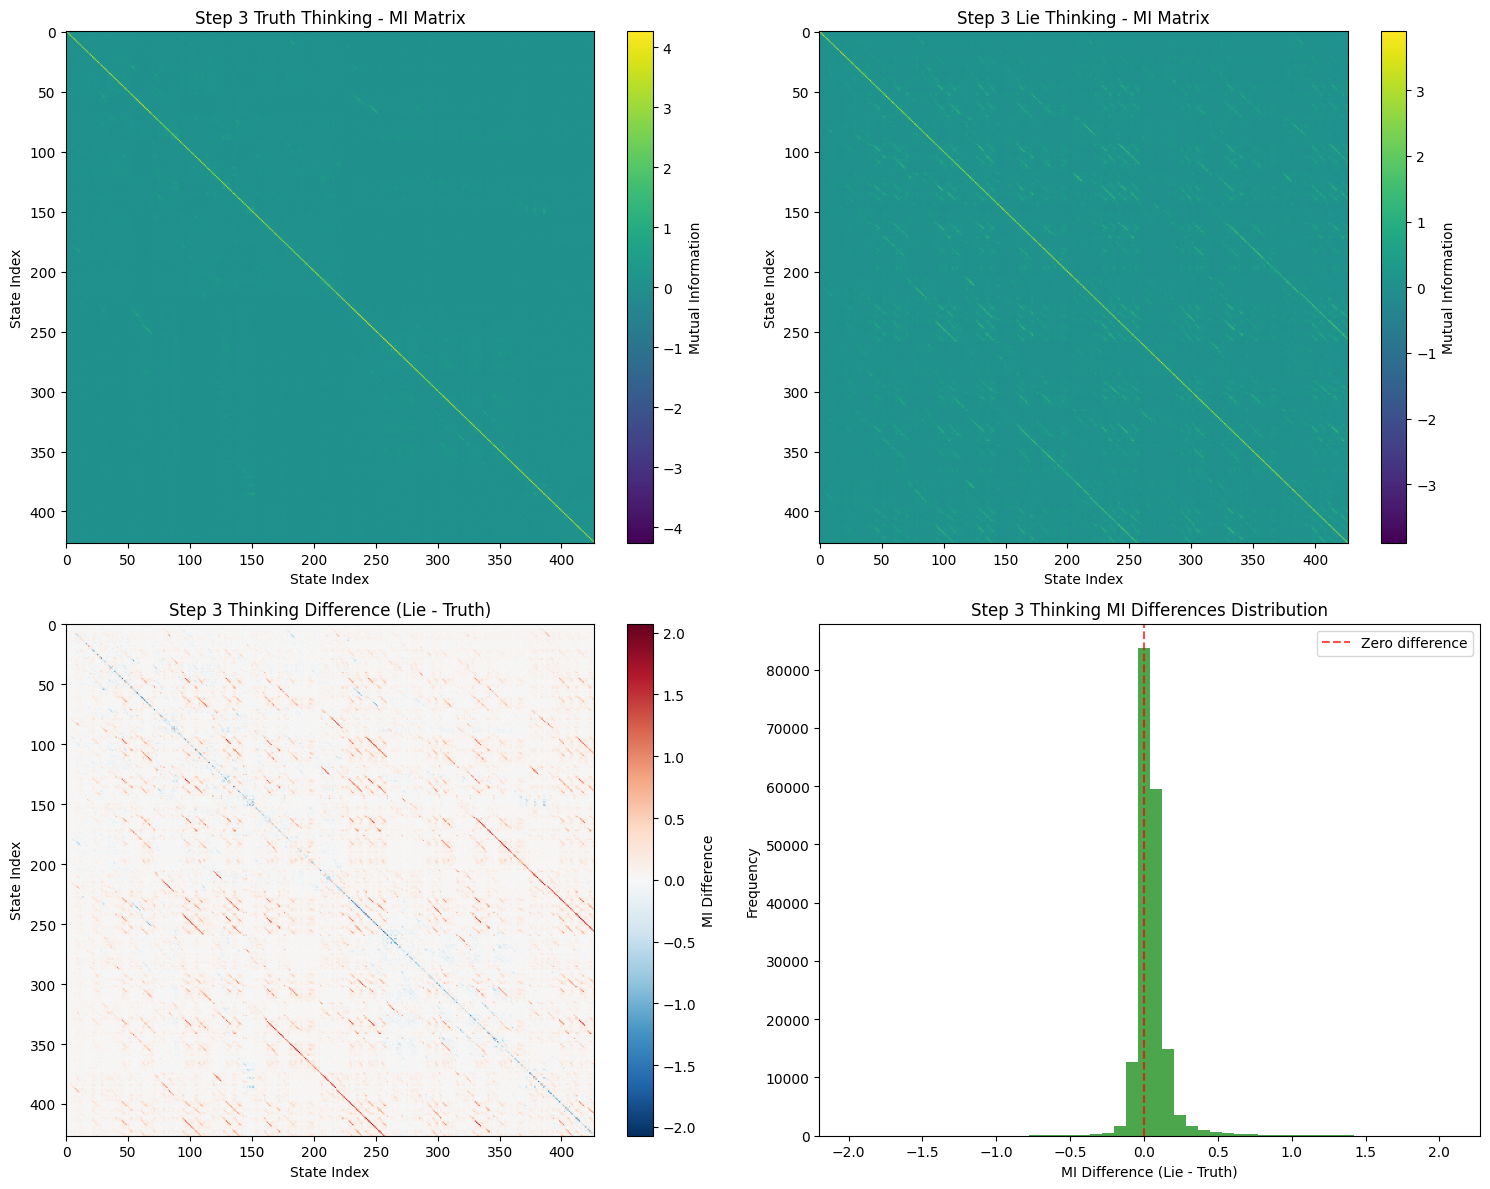


🔍 Step 3 Thinking Pattern Analysis:
Truth thinking mean off-diagonal MI: 0.0357
Lie thinking mean off-diagonal MI: 0.0846
Difference in off-diagonal MI: 0.0489
Truth thinking mean entropy (diagonal): 3.1850
Lie thinking mean entropy (diagonal): 2.6538
Difference in entropy: -0.5313

💡 Step 3 Thinking Mode Insights:
   - Thinking mode shows internal reasoning processes
   - Positive differences indicate higher MI in lie thinking
   - Negative differences indicate higher MI in truth thinking
   - Diagonal differences show entropy changes in thinking processes
   - Off-diagonal differences show information flow in reasoning


In [19]:
# Mutual Information Analysis for Step 3 (Thinking Mode Truth vs Lie)
print("🔍 Mutual Information Analysis - Step 3 Thinking Mode Truth vs Lie")
print("=" * 70)

# Analyze truth prompt with thinking mode
if 'thinking_hidden_states_truth' in locals() and len(thinking_hidden_states_truth) > 0:
    print("📊 Analyzing Truth Prompt with Thinking Mode...")
    truth_thinking_last_layer_states = [step[-1] for step in thinking_hidden_states_truth]
    mi_matrix_truth_thinking = compute_mutual_information_matrix(truth_thinking_last_layer_states, method='knn')
    print(f"Truth thinking MI matrix shape: {mi_matrix_truth_thinking.shape}")
else:
    print("⚠️ No truth thinking hidden states found for Step 3 analysis")

# Analyze lie prompt with thinking mode
if 'thinking_hidden_states_lie' in locals() and len(thinking_hidden_states_lie) > 0:
    print("📊 Analyzing Lie Prompt with Thinking Mode...")
    lie_thinking_last_layer_states = [step[-1] for step in thinking_hidden_states_lie]
    mi_matrix_lie_thinking = compute_mutual_information_matrix(lie_thinking_last_layer_states, method='knn')
    print(f"Lie thinking MI matrix shape: {mi_matrix_lie_thinking.shape}")
else:
    print("⚠️ No lie thinking hidden states found for Step 3 analysis")

# Compare truth vs lie for Step 3 (thinking mode)
if 'mi_matrix_truth_thinking' in locals() and 'mi_matrix_lie_thinking' in locals():
    print(f"\n🔄 Step 3 Thinking Mode Truth vs Lie Comparison:")
    print(f"Truth thinking matrix shape: {mi_matrix_truth_thinking.shape}")
    print(f"Lie thinking matrix shape: {mi_matrix_lie_thinking.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(mi_matrix_truth_thinking.shape[0], mi_matrix_lie_thinking.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_thinking_truncated = mi_matrix_truth_thinking[:min_size, :min_size]
    lie_thinking_truncated = mi_matrix_lie_thinking[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_thinking = lie_thinking_truncated - truth_thinking_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 3 Thinking Mode Truth vs Lie Statistics:")
    print(f"Mean MI difference (Lie - Truth): {np.mean(diff_matrix_thinking):.4f}")
    print(f"Max MI difference: {np.max(diff_matrix_thinking):.4f}")
    print(f"Min MI difference: {np.min(diff_matrix_thinking):.4f}")
    print(f"Std MI difference: {np.std(diff_matrix_thinking):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth thinking matrix - centered at 0
    vmax_mi = max(np.abs(truth_thinking_truncated.min()), np.abs(truth_thinking_truncated.max()))
    im1 = axes[0, 0].imshow(truth_thinking_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 0].set_title('Step 3 Truth Thinking - MI Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Mutual Information')
    
    # Lie thinking matrix - centered at 0
    vmax_mi = max(np.abs(lie_thinking_truncated.min()), np.abs(lie_thinking_truncated.max()))
    im2 = axes[0, 1].imshow(lie_thinking_truncated, cmap='viridis', aspect='auto', vmin=-vmax_mi, vmax=vmax_mi)
    axes[0, 1].set_title('Step 3 Lie Thinking - MI Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Mutual Information')
    
    # Difference matrix - white at 0
    vmax_diff = max(np.abs(diff_matrix_thinking.min()), np.abs(diff_matrix_thinking.max()))
    im3 = axes[1, 0].imshow(diff_matrix_thinking, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff, vmax=vmax_diff)
    axes[1, 0].set_title('Step 3 Thinking Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='MI Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_thinking.flatten(), bins=50, alpha=0.7, color='green')
    axes[1, 1].set_title('Step 3 Thinking MI Differences Distribution')
    axes[1, 1].set_xlabel('MI Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step3_thinking_mode_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step3_thinking_mode_comparison.png')}")
    
    plt.show()
    
    # Analyze specific patterns
    print(f"\n🔍 Step 3 Thinking Pattern Analysis:")
    
    # Off-diagonal elements comparison
    truth_thinking_off_diag = truth_thinking_truncated[np.triu_indices_from(truth_thinking_truncated, k=1)]
    lie_thinking_off_diag = lie_thinking_truncated[np.triu_indices_from(lie_thinking_truncated, k=1)]
    
    print(f"Truth thinking mean off-diagonal MI: {np.mean(truth_thinking_off_diag):.4f}")
    print(f"Lie thinking mean off-diagonal MI: {np.mean(lie_thinking_off_diag):.4f}")
    print(f"Difference in off-diagonal MI: {np.mean(lie_thinking_off_diag) - np.mean(truth_thinking_off_diag):.4f}")
    
    # Diagonal elements comparison (entropy)
    truth_thinking_diag = np.diag(truth_thinking_truncated)
    lie_thinking_diag = np.diag(lie_thinking_truncated)
    
    print(f"Truth thinking mean entropy (diagonal): {np.mean(truth_thinking_diag):.4f}")
    print(f"Lie thinking mean entropy (diagonal): {np.mean(lie_thinking_diag):.4f}")
    print(f"Difference in entropy: {np.mean(lie_thinking_diag) - np.mean(truth_thinking_diag):.4f}")
    
    # Save for later comparison
    step3_truth_thinking_mi_matrix = mi_matrix_truth_thinking.copy()
    step3_lie_thinking_mi_matrix = mi_matrix_lie_thinking.copy()
    
    print(f"\n💡 Step 3 Thinking Mode Insights:")
    print(f"   - Thinking mode shows internal reasoning processes")
    print(f"   - Positive differences indicate higher MI in lie thinking")
    print(f"   - Negative differences indicate higher MI in truth thinking")
    print(f"   - Diagonal differences show entropy changes in thinking processes")
    print(f"   - Off-diagonal differences show information flow in reasoning")
    
else:
    print("⚠️ Need both truth and lie thinking MI matrices for Step 3 comparison")


🔍 Phi Analysis - Step 3 Thinking Mode Truth vs Lie
📊 Analyzing Truth Prompt with Thinking Mode using Phi...
Truth thinking Phi matrix shape: (427, 427)
📊 Analyzing Lie Prompt with Thinking Mode using Phi...
Lie thinking Phi matrix shape: (682, 682)

🔄 Step 3 Thinking Mode Truth vs Lie Phi Comparison:
Truth thinking phi matrix shape: (427, 427)
Lie thinking phi matrix shape: (682, 682)
Using first 427 dimensions for comparison

📈 Step 3 Thinking Mode Truth vs Lie Phi Statistics:
Mean Phi difference (Lie - Truth): -0.0423
Max Phi difference: 1.2131
Min Phi difference: -2.0818
Std Phi difference: 0.1288
📊 Figure saved to: result/step3_thinking_phi_comparison.png


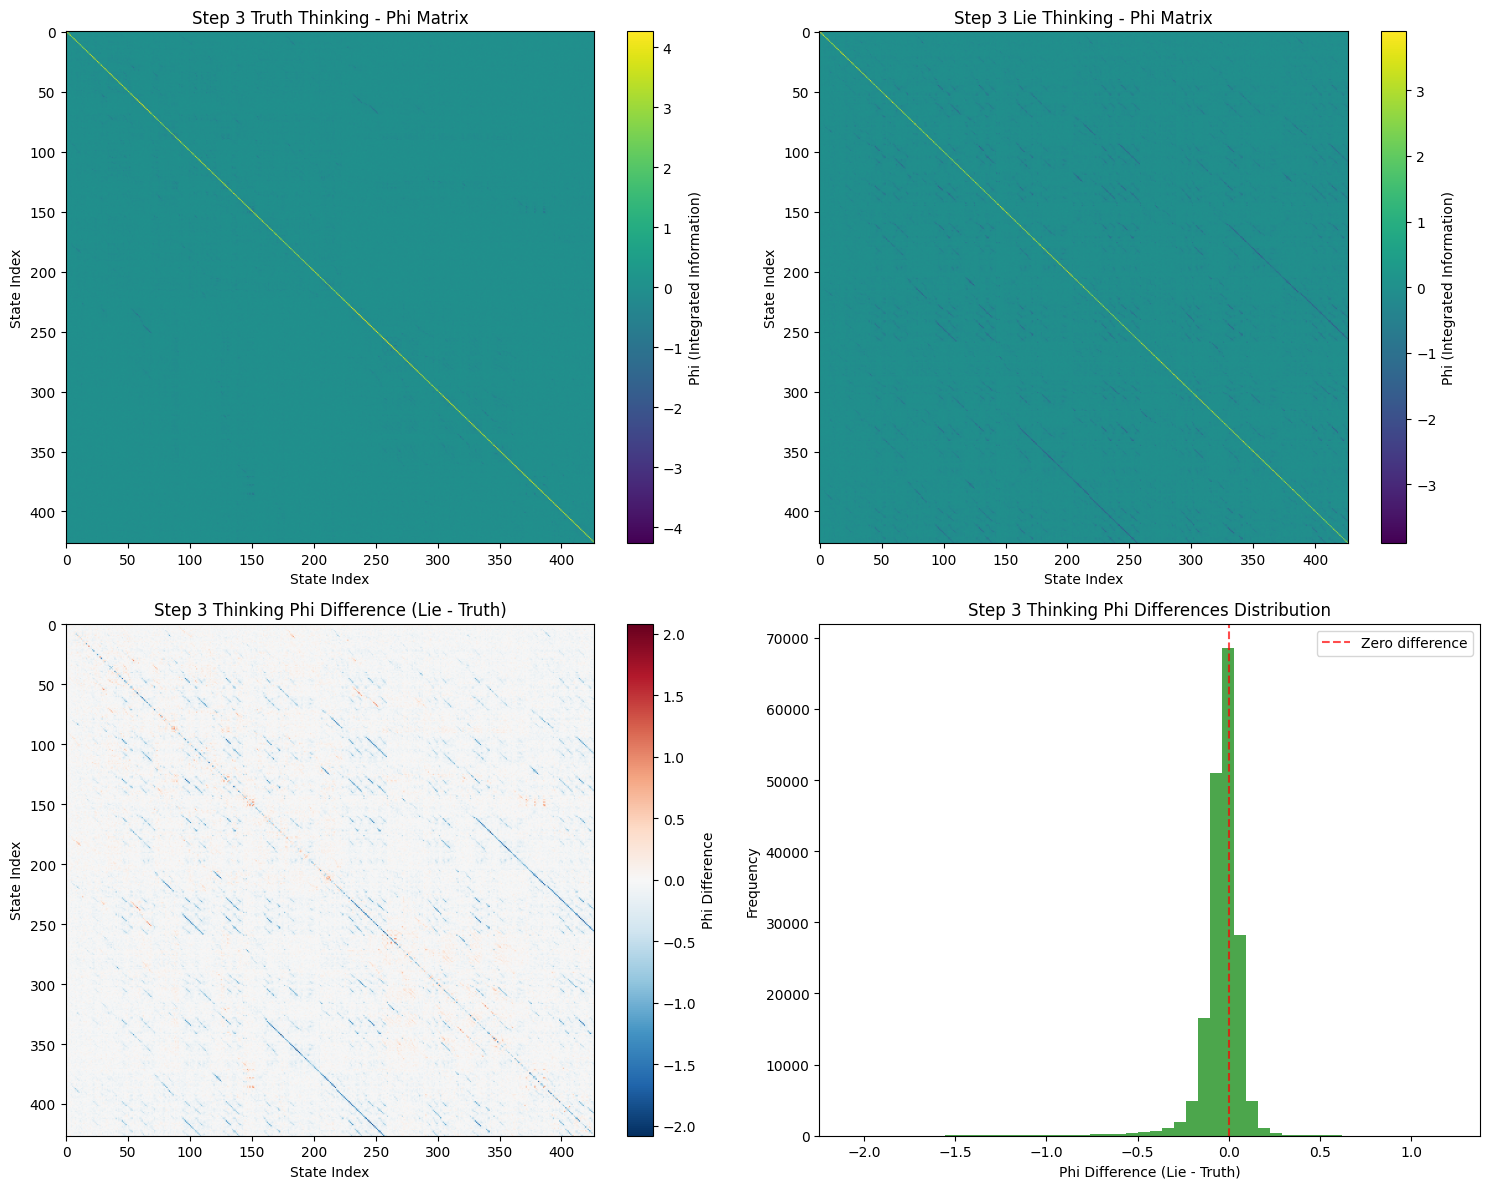


🔍 Step 3 Thinking Phi Pattern Analysis:
Truth thinking mean off-diagonal Phi: -0.0420
Lie thinking mean off-diagonal Phi: -0.0832
Difference in off-diagonal Phi: -0.0412
Truth thinking mean entropy (diagonal): 3.1850
Lie thinking mean entropy (diagonal): 2.6538
Difference in entropy: -0.5313

💡 Step 3 Thinking Mode Phi Analysis Insights:
   - Thinking mode shows internal reasoning processes with integrated information
   - Positive differences indicate higher integrated information in lie thinking
   - Negative differences indicate higher integrated information in truth thinking
   - Diagonal differences show entropy changes in thinking processes
   - Off-diagonal differences show information flow in reasoning
   - Phi measures how much information is lost when splitting the reasoning process


In [20]:
# Phi Analysis for Step 3 (Thinking Mode Truth vs Lie)
print("🔍 Phi Analysis - Step 3 Thinking Mode Truth vs Lie")
print("=" * 70)

# Analyze truth prompt with thinking mode using phi
if 'thinking_hidden_states_truth' in locals() and len(thinking_hidden_states_truth) > 0:
    print("📊 Analyzing Truth Prompt with Thinking Mode using Phi...")
    truth_thinking_last_layer_states = [step[-1] for step in thinking_hidden_states_truth]
    phi_matrix_truth_thinking = compute_mutual_information_matrix(truth_thinking_last_layer_states, method='phi', split_index=torch.numel(truth_thinking_last_layer_states[0])//2)
    print(f"Truth thinking Phi matrix shape: {phi_matrix_truth_thinking.shape}")
else:
    print("⚠️ No truth thinking hidden states found for Step 3 phi analysis")

# Analyze lie prompt with thinking mode using phi
if 'thinking_hidden_states_lie' in locals() and len(thinking_hidden_states_lie) > 0:
    print("📊 Analyzing Lie Prompt with Thinking Mode using Phi...")
    lie_thinking_last_layer_states = [step[-1] for step in thinking_hidden_states_lie]
    phi_matrix_lie_thinking = compute_mutual_information_matrix(lie_thinking_last_layer_states, method='phi', split_index=torch.numel(lie_thinking_last_layer_states[0])//2)
    print(f"Lie thinking Phi matrix shape: {phi_matrix_lie_thinking.shape}")
else:
    print("⚠️ No lie thinking hidden states found for Step 3 phi analysis")

# Compare truth vs lie for Step 3 (thinking mode) with phi
if 'phi_matrix_truth_thinking' in locals() and 'phi_matrix_lie_thinking' in locals():
    print(f"\n🔄 Step 3 Thinking Mode Truth vs Lie Phi Comparison:")
    print(f"Truth thinking phi matrix shape: {phi_matrix_truth_thinking.shape}")
    print(f"Lie thinking phi matrix shape: {phi_matrix_lie_thinking.shape}")
    
    # Handle different dimensions by using the smaller matrix size
    min_size = min(phi_matrix_truth_thinking.shape[0], phi_matrix_lie_thinking.shape[0])
    print(f"Using first {min_size} dimensions for comparison")
    
    # Truncate both matrices to the same size
    truth_thinking_phi_truncated = phi_matrix_truth_thinking[:min_size, :min_size]
    lie_thinking_phi_truncated = phi_matrix_lie_thinking[:min_size, :min_size]
    
    # Calculate difference matrix
    diff_matrix_thinking_phi = lie_thinking_phi_truncated - truth_thinking_phi_truncated
    
    # Print comparison statistics
    print(f"\n📈 Step 3 Thinking Mode Truth vs Lie Phi Statistics:")
    print(f"Mean Phi difference (Lie - Truth): {np.mean(diff_matrix_thinking_phi):.4f}")
    print(f"Max Phi difference: {np.max(diff_matrix_thinking_phi):.4f}")
    print(f"Min Phi difference: {np.min(diff_matrix_thinking_phi):.4f}")
    print(f"Std Phi difference: {np.std(diff_matrix_thinking_phi):.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Truth thinking phi matrix - centered at 0
    vmax_phi = max(np.abs(truth_thinking_phi_truncated.min()), np.abs(truth_thinking_phi_truncated.max()))
    im1 = axes[0, 0].imshow(truth_thinking_phi_truncated, cmap='viridis', aspect='auto', vmin=-vmax_phi, vmax=vmax_phi)
    axes[0, 0].set_title('Step 3 Truth Thinking - Phi Matrix')
    axes[0, 0].set_xlabel('State Index')
    axes[0, 0].set_ylabel('State Index')
    plt.colorbar(im1, ax=axes[0, 0], label='Phi (Integrated Information)')
    
    # Lie thinking phi matrix - centered at 0
    vmax_phi = max(np.abs(lie_thinking_phi_truncated.min()), np.abs(lie_thinking_phi_truncated.max()))
    im2 = axes[0, 1].imshow(lie_thinking_phi_truncated, cmap='viridis', aspect='auto', vmin=-vmax_phi, vmax=vmax_phi)
    axes[0, 1].set_title('Step 3 Lie Thinking - Phi Matrix')
    axes[0, 1].set_xlabel('State Index')
    axes[0, 1].set_ylabel('State Index')
    plt.colorbar(im2, ax=axes[0, 1], label='Phi (Integrated Information)')
    
    # Difference matrix - white at 0
    vmax_diff_phi = max(np.abs(diff_matrix_thinking_phi.min()), np.abs(diff_matrix_thinking_phi.max()))
    im3 = axes[1, 0].imshow(diff_matrix_thinking_phi, cmap='RdBu_r', aspect='auto', vmin=-vmax_diff_phi, vmax=vmax_diff_phi)
    axes[1, 0].set_title('Step 3 Thinking Phi Difference (Lie - Truth)')
    axes[1, 0].set_xlabel('State Index')
    axes[1, 0].set_ylabel('State Index')
    plt.colorbar(im3, ax=axes[1, 0], label='Phi Difference')
    
    # Statistical comparison
    axes[1, 1].hist(diff_matrix_thinking_phi.flatten(), bins=50, alpha=0.7, color='green')
    axes[1, 1].set_title('Step 3 Thinking Phi Differences Distribution')
    axes[1, 1].set_xlabel('Phi Difference (Lie - Truth)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(0, color='red', linestyle='--', alpha=0.7, label='Zero difference')
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs(export_dir, exist_ok=True)
    plt.savefig(os.path.join(export_dir, 'step3_thinking_phi_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"📊 Figure saved to: {os.path.join(export_dir, 'step3_thinking_phi_comparison.png')}")
    
    plt.show()
    
    # Analyze specific patterns
    print(f"\n🔍 Step 3 Thinking Phi Pattern Analysis:")
    
    # Off-diagonal elements comparison
    truth_thinking_phi_off_diag = truth_thinking_phi_truncated[np.triu_indices_from(truth_thinking_phi_truncated, k=1)]
    lie_thinking_phi_off_diag = lie_thinking_phi_truncated[np.triu_indices_from(lie_thinking_phi_truncated, k=1)]
    
    print(f"Truth thinking mean off-diagonal Phi: {np.mean(truth_thinking_phi_off_diag):.4f}")
    print(f"Lie thinking mean off-diagonal Phi: {np.mean(lie_thinking_phi_off_diag):.4f}")
    print(f"Difference in off-diagonal Phi: {np.mean(lie_thinking_phi_off_diag) - np.mean(truth_thinking_phi_off_diag):.4f}")
    
    # Diagonal elements comparison (entropy)
    truth_thinking_phi_diag = np.diag(truth_thinking_phi_truncated)
    lie_thinking_phi_diag = np.diag(lie_thinking_phi_truncated)
    
    print(f"Truth thinking mean entropy (diagonal): {np.mean(truth_thinking_phi_diag):.4f}")
    print(f"Lie thinking mean entropy (diagonal): {np.mean(lie_thinking_phi_diag):.4f}")
    print(f"Difference in entropy: {np.mean(lie_thinking_phi_diag) - np.mean(truth_thinking_phi_diag):.4f}")
    
    # Save for later comparison
    step3_truth_thinking_phi_matrix = phi_matrix_truth_thinking.copy()
    step3_lie_thinking_phi_matrix = phi_matrix_lie_thinking.copy()
    
    print(f"\n💡 Step 3 Thinking Mode Phi Analysis Insights:")
    print(f"   - Thinking mode shows internal reasoning processes with integrated information")
    print(f"   - Positive differences indicate higher integrated information in lie thinking")
    print(f"   - Negative differences indicate higher integrated information in truth thinking")
    print(f"   - Diagonal differences show entropy changes in thinking processes")
    print(f"   - Off-diagonal differences show information flow in reasoning")
    print(f"   - Phi measures how much information is lost when splitting the reasoning process")
    
else:
    print("⚠️ Need both truth and lie thinking Phi matrices for Step 3 comparison")
